# Interactive Occlusion Heatmap slider for all models

For a given patient id the occlusion heatmap is calculated for all models and displayed in a slider.
The size of the occlusion can be adjusted manually.

### Imports

In [1]:
import os 
import pandas as pd
import numpy as np
import h5py
import tqdm
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.metrics import confusion_matrix, roc_curve, auc

#import functions_read_data as rdat
# Tensorflow/Keras
import tensorflow as tf
print(tf.__version__)
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard

DIR = "/tf/notebooks/schnemau/xAI_stroke_3d/"
os.chdir(DIR)
print(os.getcwd())
IMG_DIR = "/tf/notebooks/hezo/stroke_perfusion/data/"
OUTPUT_DIR = "/tf/notebooks/schnemau/xAI_stroke_3d/data/"
path_img = IMG_DIR + 'dicom_2d_192x192x3_clean_interpolated_18_02_2021_preprocessed2.h5'
path_tab = IMG_DIR + 'baseline_data_zurich_prepared.csv'


# Own functions
from functions.plot_slices import plot_slices
# ontram functions
from k_ontram_functions.ontram import ontram
from k_ontram_functions.ontram_loss import ontram_loss
from k_ontram_functions.ontram_metrics import ontram_acc, ontram_auc
from k_ontram_functions.ontram_predict import predict_ontram, get_parameters
from functions.augmentation3d import zoom, rotate, flip, shift

import functions_model_definition as md
import functions_read_data as rdat
import functions_occlusion as oc
import functions_gradcam as gc
import functions_plot_heatmap as phm
import functions_slider as sl
import Utils_maurice as utils

2.2.0
/tf/notebooks/schnemau/xAI_stroke_3d


Using TensorFlow backend.


### Load Data and Set Parameters

In [2]:
which_split = 6
(train_idx, valid_idx, test_idx, X, X_train, X_valid, X_test, X_tab_train, X_tab_valid, X_tab_testt), (Y_train, Y_valid, Y_test), results, results2 = utils.read_and_split_img_data_andrea_maurice2(
    path_img = IMG_DIR + 'dicom_2d_192x192x3_clean_interpolated_18_02_2021_preprocessed2.h5', 
    path_tab = IMG_DIR + 'baseline_data_zurich_prepared.csv', 
    path_splits = '/tf/notebooks/schnemau/xAI_stroke_3d/data/andrea_splits.csv', 
    split = which_split)

Y_train_MRS = to_categorical(Y_train)
Y_valid_MRS = to_categorical(Y_valid)
Y_test_MRS = to_categorical(Y_test)

## Model

# Occlusion without slider

In [3]:
layer_connection = "globalAveragePooling"
last_activation = "sigmoid"
input_dim = np.expand_dims(X_train, axis = -1).shape[1:]
output_dim = 1

model_3d = md.stroke_binary_3d(input_dim = input_dim,
                               output_dim = output_dim,
                               layer_connection = layer_connection,
                               last_activation = last_activation)
model_3d.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=5*1e-5),
    metrics=["acc", tf.keras.metrics.AUC()]
)

In [4]:
results = pd.read_csv("/tf/notebooks/schnemau/xAI_stroke_3d/data/all_tab_results_andrea_split.csv")
results = results[results['test_split'] == 6]

In [5]:
res_table = pd.DataFrame(results.iloc[0]).transpose()
res_table

,p_idx,p_id,mrs,unfavorable,test_split,y_pred_model_0,y_pred_model_1,y_pred_model_2,y_pred_model_3,y_pred_model_4,y_pred_linear_avg,y_pred_trafo_avg,threshold,y_pred_class,y_pred_std,y_pred_unc,pred_correct
205,372,516,1,0,6,0.0332089,0.0360665,0.0219242,0.0367649,0.0152553,0.028644,0.027183,0.214277,0,0.0095694,0.023752,True


In [6]:
res_model_names = [
    [
    "/tf/notebooks/schnemau/xAI_stroke_3d/weights/andrea_split/3d_cnn_binary_model_split6_unnormalized_avg_layer_paper_model_sigmoid_activation_10.h5",
    "/tf/notebooks/schnemau/xAI_stroke_3d/weights/andrea_split/3d_cnn_binary_model_split6_unnormalized_avg_layer_paper_model_sigmoid_activation_11.h5",
    "/tf/notebooks/schnemau/xAI_stroke_3d/weights/andrea_split/3d_cnn_binary_model_split6_unnormalized_avg_layer_paper_model_sigmoid_activation_12.h5",
    "/tf/notebooks/schnemau/xAI_stroke_3d/weights/andrea_split/3d_cnn_binary_model_split6_unnormalized_avg_layer_paper_model_sigmoid_activation_13.h5",
    "/tf/notebooks/schnemau/xAI_stroke_3d/weights/andrea_split/3d_cnn_binary_model_split6_unnormalized_avg_layer_paper_model_sigmoid_activation_14.h5"
         ]
]

In [7]:
res_images = X[res_table['p_idx'].astype(int)]
imgs = np.expand_dims(res_images, axis = -1)

Two different occlusions are recommended.  
However, the occlusion can also be defined by the user. The third row of the following output must be all 0 and the fourth row must be True and the occlusion will work.

In [8]:
### occlusion
# occ_size = (16, 16, 12)
# occ_stride = 8
occ_size = (14, 14, 10)
occ_stride = 6
print("number of occlusions: ", int(np.prod(((np.array(res_images.shape[1:4]) - occ_size) / occ_stride) + 1)))
print("number of occlusions per axis: ", ((np.array(res_images.shape[1:4]) - occ_size) / occ_stride) + 1)
print((np.asarray(res_images.shape[1:4]) - occ_size) % occ_stride) # all must be zero
print(all(np.array(occ_size) > occ_stride)) # must be true
print(np.array(res_images.shape[1:4]) / occ_size) # if all same, then same ratio of occ_size to image size

number of occlusions:  1600
number of occlusions per axis:  [20. 20.  4.]
[0 0 0]
True
[9.14285714 9.14285714 2.8       ]


In [ ]:
def volume_occlusion2(volume, res_tab, 
                     occlusion_size, 
                     cnn, model_names,
                     normalize = True,
                     both_directions = False,
                     invert_hm = "pred_class",
                     model_mode = "mean",
                     occlusion_stride = None,
                     input_shape = (128,128,28,1)):
    # volume: np array in shape of input_shape
    # res_tab: dataframe with results of all models
    # occlusion_size: scalar or 3 element array, if scalar, occlusion is cubic
    # cnn: keras model
    # model_names: list of model names, to load weights
    # normalize: bool, if True, heatmap is normalized to [0,1] (after each model, and after averaging)
    # both_directions: bool, if True, heatmap is calculated for positive and negative prediction impact, if False,
    #           heatmap is cut off at the non-occluded prediction probability and only negative impact is shown
    # invert_hm: string, one of ["pred_class", "always", "never"], if "pred_class", heatmap is inverted if
    #           class 1 is predicted, if "always", heatmap is always inverted, if "never", heatmap is never inverted
    # model_mode: string, one of ["mean", "median", "max"], defines how the heatmaps of the different models are combined
    # occlusion_stride: scalar, stride of occlusion, if None, stride is set to minimum of occlusion_size
    # input_shape: tuple, shape of input volume
    
    ## Check input
    valid_modes = ["mean", "median", "max"]
    if model_mode not in valid_modes:
        raise ValueError("volume_occlusion: model_mode must be one of %r." % valid_modes)
    
    valid_inverts = ["pred_class", "always", "never"]
    if invert_hm not in valid_inverts:
        raise ValueError("volume_occlusion: invert_hm must be one of %r." % valid_inverts)

    if not isinstance(model_names, list):
        model_names = [model_names]
    
    volume = volume.reshape(input_shape)
    
    if len(occlusion_size) == 1:
        occlusion_size = np.array([occlusion_size, occlusion_size, occlusion_size])
    elif len(occlusion_size) != 3:
        raise ValueError('occluson_size must be a scalar or a 3 element array')

    if occlusion_stride is None:
        occlusion_stride = np.min(occlusion_size)
    elif any(occlusion_stride > occlusion_size):
        raise ValueError('stride must be smaller or equal size')
    
    if any(occlusion_stride == occlusion_size):
        if (not (volume.shape[0] / occlusion_size)[0].is_integer() or
            not (volume.shape[1] / occlusion_size)[1].is_integer() or 
            not (volume.shape[2] / occlusion_size)[2].is_integer()):
            
            raise ValueError('size does not work with this volume')
    elif any(occlusion_stride != occlusion_size):
        if (((volume.shape[0]-occlusion_size[0]) % occlusion_stride) != 0 or 
            ((volume.shape[1]-occlusion_size[1]) % occlusion_stride) != 0 or
            ((volume.shape[2]-occlusion_size[2]) % occlusion_stride) != 0):
        
            raise ValueError('shape and size do not match')

    # num_occlusion =  int(np.prod(((np.array(volume.shape[0:3]) - occlusion_size) / occlusion_stride) + 1))
    # print('number of occlusions per model: ', num_occlusion)
    
    ## loop over models
    h_l = []
    for j in range(5):
        cnn.load_weights(model_names[0][j])
        
        heatmap_prob_sum = np.zeros((volume.shape[0], volume.shape[1], volume.shape[2]), np.float32)
        heatmap_occ_n = np.zeros((volume.shape[0], volume.shape[1], volume.shape[2]), np.float32)

        ## Faster Implementation
        
        ## Generate all possible occlusions
        X = []
        xyz = []
        for n, (x, y, z, vol_float) in enumerate(oc.iter_occlusion(
                volume, size = occlusion_size, stride = occlusion_stride)):
            X.append(vol_float.reshape(volume.shape[0], volume.shape[1], volume.shape[2], 1))
            xyz.append((x,y,z))
        
        X = np.array(X)
        out = cnn.predict(X) # do prediction for all occlusions at once 
        
        ## Add predictions to heatmap and count number of predictions per voxel
        for i in range(len(xyz)):
            x,y,z = xyz[i]
            heatmap_prob_sum[x:x + occlusion_size[0], y:y + occlusion_size[1], z:z + occlusion_size[2]] += out[i,0]
            heatmap_occ_n[x:x + occlusion_size[0], y:y + occlusion_size[1], z:z + occlusion_size[2]] += 1

        hm = heatmap_prob_sum / heatmap_occ_n # calculate average probability per voxel
        
        ## Get cutoff, invert heatmap if necessary and normalize
        cut_off = res_tab["y_pred_model_" + str(j)].values[0]
    
        if (res_tab["y_pred_class"].values[0] == 0 and invert_hm == "pred_class" and not both_directions) or (
            invert_hm == "never" and not both_directions): 
            hm[hm < cut_off] = cut_off
        elif (res_tab["y_pred_class"].values[0] == 1 and invert_hm == "pred_class" and not both_directions) or (
            invert_hm == "always" and not both_directions):
            hm[hm > cut_off] = cut_off
        elif both_directions:
            hm = hm - cut_off
        
        if normalize and not both_directions:
            hm = ((hm - hm.min())/(hm.max()-hm.min()))
        elif normalize and both_directions:
            hm_min_max = [np.min(hm), np.max(hm)]
            hm_abs_max = np.max(np.abs(hm_min_max))
            hm = hm / hm_abs_max
        
        h_l.append(hm)
        
    ## Average over all models
    h_l = np.array(h_l)
    h_l = np.expand_dims(h_l, axis = -1)
    if model_mode == "mean":
        heatmap = np.mean(h_l, axis = 0)
    elif model_mode == "median":
        heatmap = np.median(h_l, axis = 0)
    elif model_mode == "max":
        heatmap = np.max(h_l, axis = 0)
        
    if normalize and not both_directions:
        heatmap = ((heatmap - heatmap.min())/(heatmap.max()-heatmap.min()))
    elif normalize and both_directions:
        heatmap_min_max = [np.min(heatmap), np.max(heatmap)]
        heatmap_abs_max = np.max(np.abs(heatmap_min_max))
        heatmap = heatmap / heatmap_abs_max
        
    if invert_hm == "pred_class" and res_tab["y_pred_class"].values[0] == 1:
        heatmap = 1 - heatmap  
    elif invert_hm == "always":
        heatmap = 1 - heatmap
        
    ## Get maximum heatmap slice and standard deviation of heatmaps
    target_shape = h_l.shape[:-1]
    max_hm_slice = np.array(np.unravel_index(h_l.reshape(target_shape).reshape(len(h_l), -1).argmax(axis = 1), 
                                             h_l.reshape(target_shape).shape[1:])).transpose()
    hm_mean_std = np.sqrt(np.mean(np.var(h_l, axis = 0)))
    
    return heatmap, volume, max_hm_slice, hm_mean_std


In [9]:
import time
from importlib import reload
reload(oc)

start = time.time()
(heatmap, resized_img, max_hm_slice, hm_mean_std) =  oc.volume_occlusion(
    volume = res_images, 
    res_tab = res_table, 
    occlusion_size = np.array(occ_size), 
    normalize = True,
    both_directions = False,
    invert_hm = "pred_class",
    cnn = model_3d,
    model_names = res_model_names[0][:], # select model
    occlusion_stride = occ_stride)

end = time.time()
print(end - start)

KeyError: 0

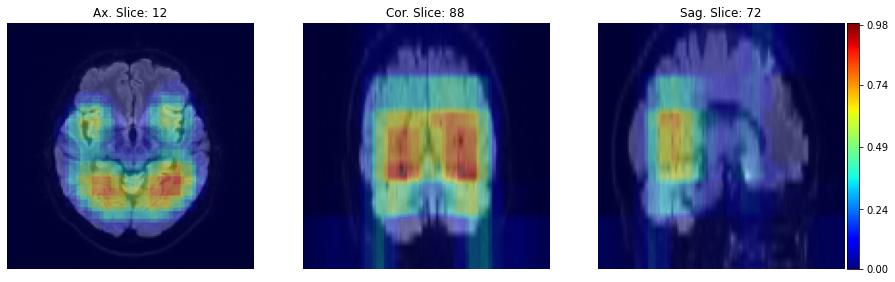

In [18]:
phm.plot_heatmap(np.squeeze(resized_img, axis=-1), np.squeeze(heatmap, axis=-1),
                version = "overlay",
                mode = "def",
                slices = (88,72,12),
                hm_colormap="jet",
                hm_positive=True,
                colorbar=True)

# Occlusion Slider

patient id:  162
age:  75,3
true mrs:  0.0
true class:  0
pred class: 0
pred prob (class 1):  0.2245433
pred uncertainty:  0.35809875
max slices: (10, 44, 74)


TypeError: Invalid shape (128, 128, 1) for image data

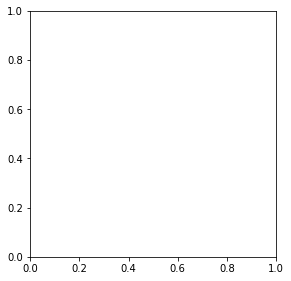

In [19]:
# occ_size = (16, 16, 12)
# occ_stride = 8
occ_size = (14, 14, 10)
occ_stride = 6

sl.occlusion_interactive_plot(
    162, # patient id
    occ_size = occ_size, occ_stride = occ_stride,
    cnn=model_3d, all_results=all_results, pat=pat, X_in=X_in,
    generate_model_name=generate_model_name, num_models=num_models,
    pat_dat=pat_dat,
    pred_hm_only=True) # if True, only the heatmap for the predicted class is shown, otherwise also negative heatmaps are shown

### Maurice

In [11]:
print(X_in.shape)
print(np.expand_dims(X_in, axis = -1).shape)

(407, 128, 128, 28)
(407, 128, 128, 28, 1)


In [12]:
imgs22 = np.expand_dims(X_in, axis = -1)
np.array(imgs22)
imgs22[14]

array([[[[-0.5798917],
         [-0.5798917],
         [-0.5798917],
         ...,
         [-0.5798917],
         [-0.5798917],
         [-0.5798917]],

        [[-0.5798917],
         [-0.5798917],
         [-0.5798917],
         ...,
         [-0.5798917],
         [-0.536904 ],
         [-0.5798917]],

        [[-0.5798917],
         [-0.5798917],
         [-0.5798917],
         ...,
         [-0.5798917],
         [-0.5798917],
         [-0.5798917]],

        ...,

        [[-0.5798917],
         [-0.5798917],
         [-0.5798917],
         ...,
         [-0.5798917],
         [-0.536904 ],
         [-0.5798917]],

        [[-0.5798917],
         [-0.5798917],
         [-0.5798917],
         ...,
         [-0.5798917],
         [-0.5798917],
         [-0.5798917]],

        [[-0.5798917],
         [-0.5798917],
         [-0.5798917],
         ...,
         [-0.5798917],
         [-0.536904 ],
         [-0.5798917]]],


       [[[-0.5798917],
         [-0.5798917],
         [-0.5

In [13]:
occ_size = (14, 14, 10)
occ_stride = 6
volume = imgs22[14]#TODO
occlusion_size = np.array(occ_size)
normalize = True
both_directions = False
invert_hm = "pred_class"
occlusion_stride = occ_stride
input_shape = (128,128,28,1) #TODO
volume = volume.reshape(input_shape)

In [14]:
heatmap_prob_sum = np.zeros((volume.shape[0], volume.shape[1], volume.shape[2]), np.float32)
heatmap_occ_n = np.zeros((volume.shape[0], volume.shape[1], volume.shape[2]), np.float32)

In [15]:
X = []
xyz = []
for n, (x, y, z, vol_float) in enumerate(oc.iter_occlusion(
        volume, size = occlusion_size, stride = occlusion_stride)):
    X.append(vol_float.reshape(volume.shape[0], volume.shape[1], volume.shape[2], 1))
    xyz.append((x,y,z))

X = np.array(X)
out = model_3d.predict(X) # do prediction for all occlusions at once 

In [37]:
out

array([[0.16365772],
       [0.14762732],
       [0.15605837],
       ...,
       [0.14432353],
       [0.15703398],
       [0.16184306]], dtype=float32)

In [38]:
out[1,0]

0.14762732

In [39]:
for i in range(len(xyz)):
    x,y,z = xyz[i]
    heatmap_prob_sum[x:x + occlusion_size[0], y:y + occlusion_size[1], z:z + occlusion_size[2]] += out[i,0]
    heatmap_occ_n[x:x + occlusion_size[0], y:y + occlusion_size[1], z:z + occlusion_size[2]] += 1

hm = heatmap_prob_sum / heatmap_occ_n # calculate average probability per voxel

In [40]:
hm

array([[[0.16365772, 0.16365772, 0.16365772, ..., 0.16335604,
         0.16335604, 0.16335604],
        [0.16365772, 0.16365772, 0.16365772, ..., 0.16335604,
         0.16335604, 0.16335604],
        [0.16365772, 0.16365772, 0.16365772, ..., 0.16335604,
         0.16335604, 0.16335604],
        ...,
        [0.16329187, 0.16329187, 0.16329187, ..., 0.16195145,
         0.16195145, 0.16195145],
        [0.16329187, 0.16329187, 0.16329187, ..., 0.16195145,
         0.16195145, 0.16195145],
        [0.16329187, 0.16329187, 0.16329187, ..., 0.16195145,
         0.16195145, 0.16195145]],

       [[0.16365772, 0.16365772, 0.16365772, ..., 0.16335604,
         0.16335604, 0.16335604],
        [0.16365772, 0.16365772, 0.16365772, ..., 0.16335604,
         0.16335604, 0.16335604],
        [0.16365772, 0.16365772, 0.16365772, ..., 0.16335604,
         0.16335604, 0.16335604],
        ...,
        [0.16329187, 0.16329187, 0.16329187, ..., 0.16195145,
         0.16195145, 0.16195145],
        [0.1

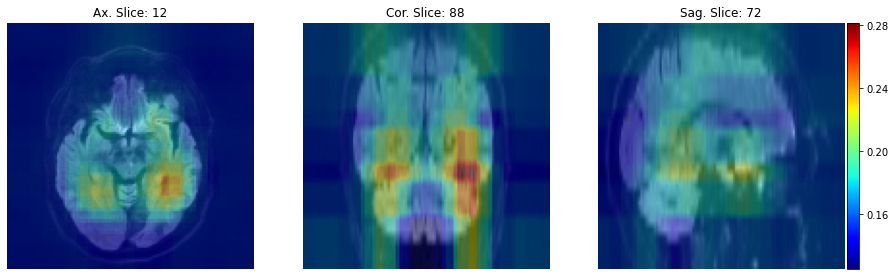

In [46]:
phm.plot_heatmap(X_in[14], hm,
                version = "overlay",
                mode = "def",
                slices = (88,72,12),
                hm_colormap="jet",
                hm_positive=True,
                colorbar=True)

In [47]:
X_in[0]

array([[[-0.58437234, -0.58437234, -0.58437234, ..., -0.58437234,
         -0.58437234, -0.58437234],
        [-0.58437234, -0.58437234, -0.58437234, ..., -0.58437234,
         -0.58437234, -0.58437234],
        [-0.58437234, -0.58437234, -0.58437234, ..., -0.58437234,
         -0.58437234, -0.58437234],
        ...,
        [-0.58437234, -0.58437234, -0.58437234, ..., -0.58437234,
         -0.58437234, -0.58437234],
        [-0.58437234, -0.58437234, -0.58437234, ..., -0.58437234,
         -0.58437234, -0.58437234],
        [-0.58437234, -0.58437234, -0.58437234, ..., -0.58437234,
         -0.58437234, -0.58437234]],

       [[-0.58437234, -0.58437234, -0.58437234, ..., -0.58437234,
         -0.58437234, -0.58437234],
        [-0.58437234, -0.58437234, -0.58437234, ..., -0.58437234,
         -0.58437234, -0.58437234],
        [-0.58437234, -0.58437234, -0.58437234, ..., -0.58437234,
         -0.58437234, -0.58437234],
        ...,
        [-0.58437234, -0.58437234, -0.58437234, ..., -